# Uncertainty 
## Confidence Intervals

From [Supervised Machine Learning for Science](https://ml-science-book.com/uncertainty.html) {cite:p}`freiesleben2024supervised`
* **Frequentist confidence intervals** represent the proportion of times we would see the true value of the parameter if we repeated the same experiment infinite times. 
* **Bayesian credible intervals** represent the probability that a distribution covers the true value. To construct a credible interval, we need a prior distribution.

### Frequentist Confidence Intervals

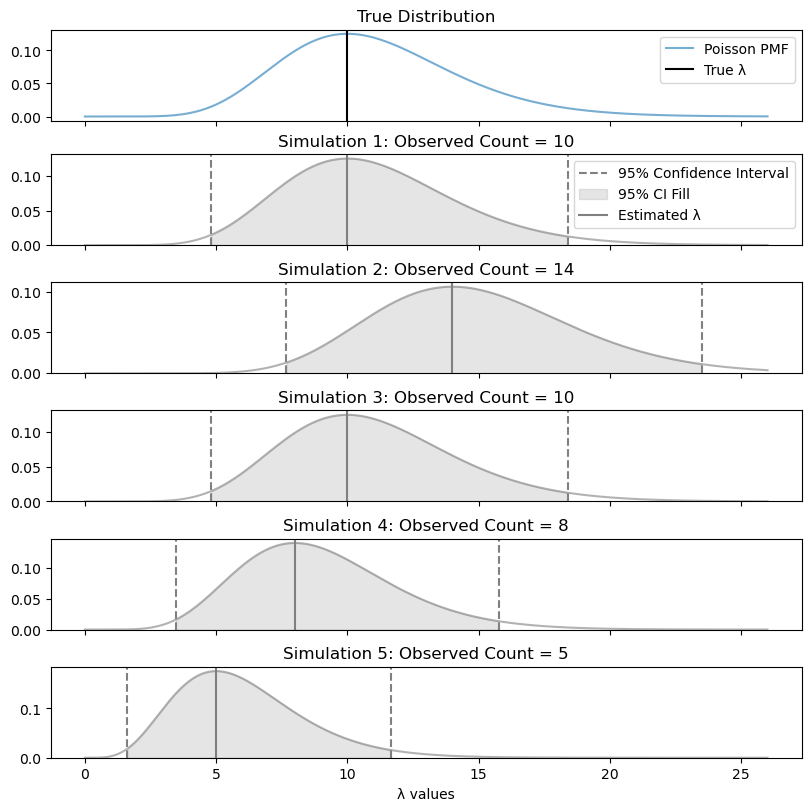

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

np.random.seed(42)
rng = np.random.default_rng(seed=42)

true_lambda = 10
n_simulations = 5

# Define a common range of λ values for all subplots
lambda_min = 0
lambda_max = true_lambda + 15 
lambda_values = np.linspace(lambda_min, lambda_max + 1, 1000)
poisson_pmf_template = stats.poisson.pmf(lambda_values, lambda_values)

fig, axes = plt.subplots(n_simulations+1, 1, figsize=(8, 8), sharex=True, constrained_layout=True)

poisson_pmf = stats.poisson.pmf(true_lambda, lambda_values)
axes[0].plot(lambda_values, poisson_pmf, color='tab:blue', alpha=0.6, label='Poisson PMF')
axes[0].axvline(true_lambda, color='black', linestyle='-', label=f'True λ')
axes[0].set_title(f'True Distribution')
axes[0].legend()

for i in range(n_simulations):
    observed_count = rng.poisson(lam=true_lambda)
    estimated_lambda = observed_count
    
    # Construct a 95% confidence interval using the Chi-Squared method
    alpha = 0.05
    if observed_count == 0:
        lower_bound = 0
        upper_bound = 0.5 * stats.chi2.ppf(1 - alpha / 2, 2 * (observed_count + 1))
    else:
        lower_bound = 0.5 * stats.chi2.ppf(alpha / 2, 2 * observed_count)
        upper_bound = 0.5 * stats.chi2.ppf(1 - alpha / 2, 2 * (observed_count + 1))
    
    poisson_pmf = stats.poisson.pmf(observed_count, lambda_values)
    
    # Plot the Poisson PMF
    ax = axes[i+1]
    ax.plot(lambda_values, poisson_pmf, color='grey', alpha=0.6)
    ax.axvline(lower_bound, color='grey', linestyle='--', label='95% Confidence Interval' if i == 0 else "")
    ax.axvline(upper_bound, color='grey', linestyle='--')
    ax.fill_between(lambda_values, poisson_pmf, where=(lambda_values >= lower_bound) & (lambda_values <= upper_bound), 
                    color='grey', alpha=0.2, label='95% CI Fill' if i == 0 else "")
    ax.axvline(estimated_lambda, color='grey', linestyle='-', label=f'Estimated λ' if i == 0 else "")
    ax.set_title(f'Simulation {i+1}: Observed Count = {observed_count}')
    ax.set_ylim(0)
    # Display the legend only in the first subplot to avoid repetition
    if i == 0:
        ax.legend()

axes[-1].set_xlabel('λ values')
plt.show()

### Baysian Credible Intervals
There are multiple definitions for credible intervals. The most common:  
- **Equal-Tailed Interval (ETI) / Quantile-Based Interval (QBI)**: This interval includes the cental $1−\alpha$ proprotion of the posterior distribution. It is symmetrical about the tails. Often used when symmetry is desired and is more analogous to a frequentist confidence interval. It is what is used below.
- **Highest Density Interval (HDI)**:  The HDI is the shortest interval that contains the specified probability mass $1−\alpha$. Every point inside the HDI has a higher posterior density than any point outside the interval. It may not symmetrically exclude tails, especially for skewed distributions like the Gamma. 

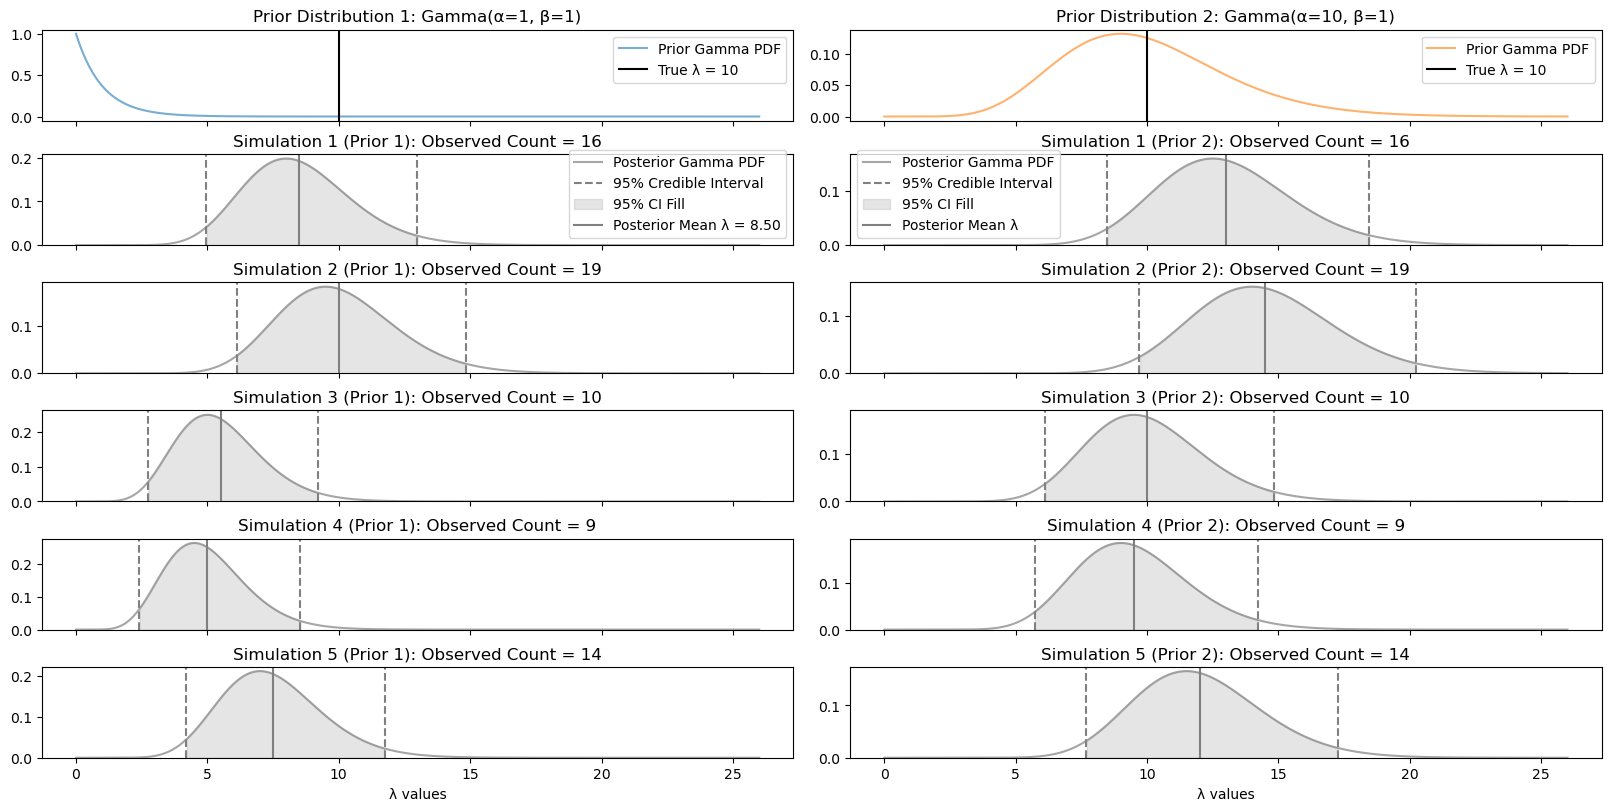

In [3]:
alpha_prior_1 = 1
beta_prior_1 = 1

alpha_prior_2 = 10
beta_prior_2 = 1

fig, axes = plt.subplots(n_simulations + 1, 2, figsize=(16, 8), sharex=True, constrained_layout=True)

# Plot Prior Distribution for the first prior (Column 1)
prior_pdf_1 = stats.gamma.pdf(lambda_values, a=alpha_prior_1, scale=1/beta_prior_1)
axes[0, 0].plot(lambda_values, prior_pdf_1, color='tab:blue', alpha=0.6, label='Prior Gamma PDF')
axes[0, 0].axvline(true_lambda, color='black', linestyle='-', label=f'True λ = {true_lambda}')
axes[0, 0].set_title(f'Prior Distribution 1: Gamma(α={alpha_prior_1}, β={beta_prior_1})')
axes[0, 0].legend()

# Plot Prior Distribution for the second prior (Column 2)
prior_pdf_2 = stats.gamma.pdf(lambda_values, a=alpha_prior_2, scale=1/beta_prior_2)
axes[0, 1].plot(lambda_values, prior_pdf_2, color='tab:orange', alpha=0.6, label='Prior Gamma PDF')
axes[0, 1].axvline(true_lambda, color='black', linestyle='-', label=f'True λ = {true_lambda}')
axes[0, 1].set_title(f'Prior Distribution 2: Gamma(α={alpha_prior_2}, β={beta_prior_2})')
axes[0, 1].legend()


for i in range(n_simulations):
    observed_count = rng.poisson(lam=true_lambda)
    
    # --- Using Prior 1 ---
    # Update posterior parameters for Prior 1
    alpha_post_1 = alpha_prior_1 + observed_count
    beta_post_1 = beta_prior_1 + 1  # Assuming unit time interval or known exposure
    posterior_pdf_1 = stats.gamma.pdf(lambda_values, a=alpha_post_1, scale=1/beta_post_1)
    
    # Compute 95% Bayesian Credible Interval for Posterior 1
    lower_bound_1 = stats.gamma.ppf(0.025, a=alpha_post_1, scale=1/beta_post_1)
    upper_bound_1 = stats.gamma.ppf(0.975, a=alpha_post_1, scale=1/beta_post_1)
    posterior_mean_1 = alpha_post_1 / beta_post_1
    
    # Plot posterior distribution for Prior 1
    ax1 = axes[i + 1, 0]
    ax1.plot(lambda_values, posterior_pdf_1, color='grey', alpha=0.7, label='Posterior Gamma PDF')
    ax1.axvline(lower_bound_1, color='grey', linestyle='--', label='95% Credible Interval' if i == 0 else "")
    ax1.axvline(upper_bound_1, color='grey', linestyle='--')
    ax1.fill_between(lambda_values, posterior_pdf_1, where=(lambda_values >= lower_bound_1) & (lambda_values <= upper_bound_1), 
                    color='grey', alpha=0.2, label='95% CI Fill' if i == 0 else "")
    ax1.axvline(posterior_mean_1, color='grey', linestyle='-', label=f'Posterior Mean λ = {posterior_mean_1:.2f}' if i == 0 else "")
    ax1.set_title(f'Simulation {i + 1} (Prior 1): Observed Count = {observed_count}')
    ax1.set_ylim(0)
    
    # Add legend only to the first posterior subplot in Column 1 to avoid repetition
    if i == 0:
        ax1.legend()
    
    # --- Using Prior 2 ---
    # Update posterior parameters for Prior 2
    alpha_post_2 = alpha_prior_2 + observed_count
    beta_post_2 = beta_prior_2 + 1  # Assuming unit time interval or known exposure
    posterior_pdf_2 = stats.gamma.pdf(lambda_values, a=alpha_post_2, scale=1/beta_post_2)
    
    # Compute 95% Bayesian Credible Interval for Posterior 2
    lower_bound_2 = stats.gamma.ppf(0.025, a=alpha_post_2, scale=1/beta_post_2)
    upper_bound_2 = stats.gamma.ppf(0.975, a=alpha_post_2, scale=1/beta_post_2)
    posterior_mean_2 = alpha_post_2 / beta_post_2
    
    # Plot posterior distribution for Prior 2
    ax2 = axes[i + 1, 1]
    ax2.plot(lambda_values, posterior_pdf_2, color='grey', alpha=0.7, label='Posterior Gamma PDF')
    ax2.axvline(lower_bound_2, color='grey', linestyle='--', label='95% Credible Interval' if i == 0 else "")
    ax2.axvline(upper_bound_2, color='grey', linestyle='--')
    ax2.fill_between(lambda_values, posterior_pdf_2, where=(lambda_values >= lower_bound_2) & (lambda_values <= upper_bound_2), 
                    color='grey', alpha=0.2, label='95% CI Fill' if i == 0 else "")
    ax2.axvline(posterior_mean_2, color='grey', linestyle='-', label=f'Posterior Mean λ')
    ax2.set_title(f'Simulation {i + 1} (Prior 2): Observed Count = {observed_count}')
    ax2.set_ylim(0)
    
    # Add legend only to the first posterior subplot in Column 2 to avoid repetition
    if i == 0:
        ax2.legend()

# Label the x-axis on the bottom subplots for both columns
axes[-1, 0].set_xlabel('λ values')
axes[-1, 1].set_xlabel('λ values')
plt.show()

```{bibliography}
:filter: docname in docnames
```